In [53]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

from scipy.optimize import curve_fit, minimize
from scipy.fft import fft, fftfreq

# 1.

In [54]:
def sort_by_number_particle(eigenenergies, eigenstates, annihilation_operators):  
    '''
    Finds the particle number of each state and separates the eigenenergies and eigenstates by their particle number
    '''
    
    N_op = 0
    for ai in annihilation_operators:
        N_op += ai.dag()*ai
        
    eigenenergies_particle_number = []
    eigenstates_particle_number = []

    for i in range(len(eigenenergies+1)):
        eigenenergies_particle_number.append([])
        eigenstates_particle_number.append([])


    for i in range(len(eigenstates)):
        eigenstate = eigenstates[i]
        eigenenergy = eigenenergies[i]

        particle_number = round(N_op.matrix_element(eigenstate, eigenstate).real)  
        
#         print(particle_number)

        eigenenergies_particle_number[particle_number].append(eigenenergy)
        eigenstates_particle_number[particle_number].append(eigenstate)
        
    return eigenenergies_particle_number, eigenstates_particle_number

In [55]:
def generate_Hamiltonian(omega_1, omega_2, g, U, annihilation_operators):
    
    a1, a2 = annihilation_operators
    
    H = omega_1 * a1.dag()*a1 + omega_2 * a2.dag()*a2 + U*(a1.dag()*a1*(a1.dag()*a1 - 1) + a2.dag()*a2*(a2.dag()*a2 - 1)) + g*(a1.dag()*a2 + a2.dag()*a1)
    
    return H

### 1.1 Dressed Frequencies

In [56]:
omega_1 = 0.0   * 2*np.pi # GHz
omega_2 = 0.1 * 2*np.pi # GHz

g = 0.01 * 2*np.pi # GHz
U = -0.2 * 2*np.pi # GHz

In [57]:
num_levels = 2

a = qt.destroy(num_levels)

a1 = qt.tensor(a, qt.qeye(num_levels))
a2 = qt.tensor(qt.qeye(num_levels), a)

In [58]:
H = generate_Hamiltonian(omega_1, omega_2, g, U, [a1, a2])

In [59]:
eigenenergies, eigenstates = H.eigenstates()
eigenenergies_particle_number, eigenstates_particle_number = sort_by_number_particle(eigenenergies, eigenstates, [a1, a2])

In [60]:
print(eigenenergies_particle_number[0])
print(eigenenergies_particle_number[1])

[0.0]
[-0.006221579529301913, 0.6345401102472612]


In [61]:
single_particle_energies = np.array(eigenenergies_particle_number[1])

Text(0, 0.5, 'Frequency (GHz)')

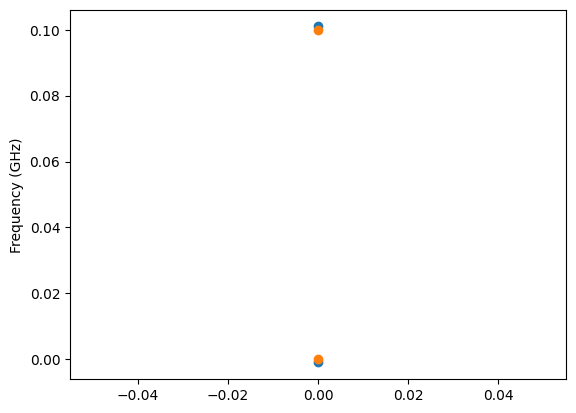

In [62]:
plt.scatter([0,0], single_particle_energies/2/np.pi, label='Dressed Frequencies')
plt.scatter([0,0], np.array([omega_1, omega_2])/2/np.pi, label='Bare Frequencies')

plt.ylabel('Frequency (GHz)')

### 1.2 Sweep Bare Frequency and measure swaps

In [63]:
omega_1 = 4.5   * 2*np.pi # GHz
omega_2 = 4.505 * 2*np.pi # GHz

g = 0.010 * 2*np.pi # GHz
U = -0.2 * 2*np.pi # GHz

times = np.linspace(0, 400, 1001)
psi0 = qt.basis([num_levels, num_levels], [1, 0])

qubit_detunings = np.linspace((omega_2 - omega_1)/2/np.pi - 0.01, (omega_2 - omega_1)/2/np.pi + 0.01, 21) * 2*np.pi # GHz
qubit_detunings = np.linspace(0, (omega_2 - omega_1)/2/np.pi + 0.01, 11) * 2*np.pi # GHz


In [64]:

dressed_frequencies = np.zeros((2, len(qubit_detunings)))
bare_frequencies = np.zeros(dressed_frequencies.shape)

populations = np.zeros((2, len(qubit_detunings), len(times)))

for i in range(len(qubit_detunings)):
    
    detuning = qubit_detunings[i]
    
    H = generate_Hamiltonian(omega_1 + detuning, omega_2, g, U, [a1, a2])
    
    # eigenenergies
    eigenenergies, eigenstates = H.eigenstates()
    eigenenergies_particle_number, eigenstates_particle_number = sort_by_number_particle(eigenenergies, eigenstates, [a1, a2])
    
    dressed_frequencies[0, i] = eigenenergies_particle_number[1][0]/2/np.pi
    dressed_frequencies[1, i] = eigenenergies_particle_number[1][1]/2/np.pi
    
    bare_frequencies[0, i] = (omega_1 + detuning)/2/np.pi
    bare_frequencies[1, i] = omega_2/2/np.pi
    
    # time evolution
    
    result = qt.sesolve(H, psi0, times, e_ops=[a1.dag()*a1, a2.dag()*a2])
    
    populations[:,i,:] = result.expect

In [65]:
print(f'Dressed frequencies at starting point')
H = generate_Hamiltonian(omega_1, omega_2, g, U, [a1, a2])
print(H)
eigenenergies, eigenstates = H.eigenstates()
print(eigenenergies)
eigenenergies_particle_number, eigenstates_particle_number = sort_by_number_particle(eigenenergies, eigenstates, [a1, a2])
print(eigenenergies_particle_number)
print(f'{np.round(eigenenergies_particle_number[1][0]/2/np.pi, 3)}')
print(f'{np.round(eigenenergies_particle_number[1][1]/2/np.pi, 3)}')


Dressed frequencies at starting point
Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dia, isherm=True
Qobj data =
[[ 0.          0.          0.          0.        ]
 [ 0.         28.30574981  0.06283185  0.        ]
 [ 0.          0.06283185 28.27433388  0.        ]
 [ 0.          0.          0.         56.58008369]]
[ 0.         28.22527625 28.35480744 56.58008369]
[[0.0], [28.22527625385901, 28.35480743729316], [56.58008369115217], []]
4.492
4.513


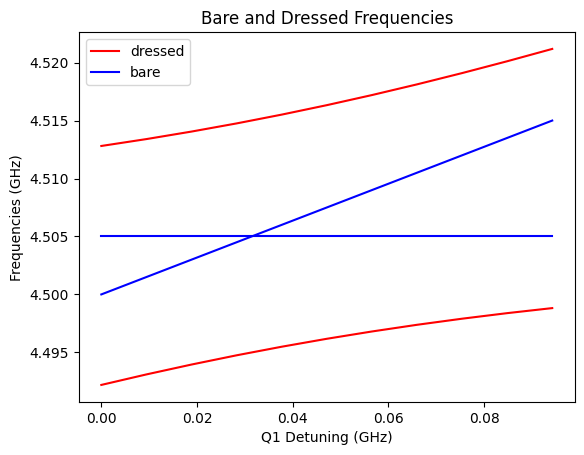

In [66]:
plt.plot(qubit_detunings, dressed_frequencies[0, :], color='red', label='dressed')
plt.plot(qubit_detunings, dressed_frequencies[1, :], color='red')

plt.plot(qubit_detunings, bare_frequencies[0, :], color='blue', label='bare')
plt.plot(qubit_detunings, bare_frequencies[1, :], color='blue')

plt.xlabel('Q1 Detuning (GHz)')
plt.ylabel('Frequencies (GHz)')

plt.title('Bare and Dressed Frequencies')

plt.legend()
plt.show()

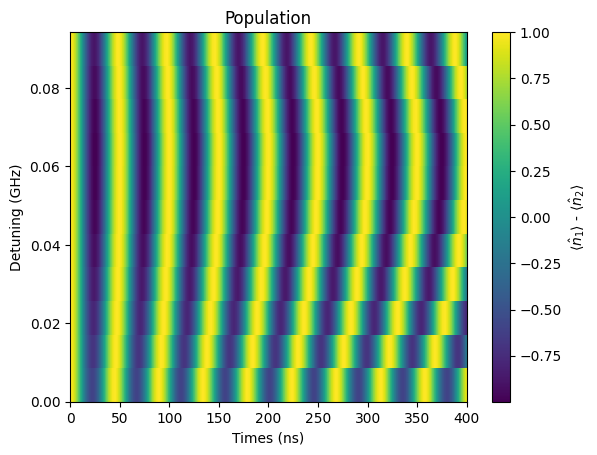

In [67]:
im = plt.imshow(populations[0,:,:] - populations[1,:,:], aspect='auto', interpolation='none', extent=(times[0], times[-1], qubit_detunings[0], qubit_detunings[-1]))

plt.xlabel('Times (ns)')
plt.ylabel('Detuning (GHz)')

plt.colorbar(im, label=r'$\langle \hat{n}_1 \rangle$ - $\langle \hat{n}_2 \rangle$')

plt.title('Population')
plt.show()


In [68]:
def cos_fit(x, A, omega, C):
    return A*np.cos(omega*x) + C

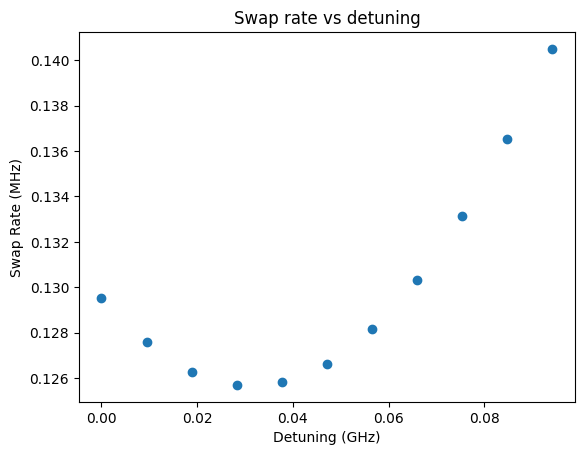

In [69]:
### fit each slice to sinusoid

plot_fits = False
swap_rates = np.zeros((len(qubit_detunings)))

for i in range(len(qubit_detunings)):
    
    
    population_difference = populations[0,i,:] - populations[1,i,:]
    
    population_difference_fft = fft(population_difference)
    
    number_of_times = len(times)
    time_spacing = times[1] - times[0]
    
    population_difference_fft_freqs = fftfreq(number_of_times, time_spacing)
    
    peak_index = np.argmax(population_difference_fft[1:number_of_times//2])
    swap_rate_guess = population_difference_fft_freqs[1:number_of_times//2][peak_index]*2*np.pi
    
    amplitude_guess = 1
    initial_guess = (amplitude_guess, swap_rate_guess, 0)
    bounds = ((-np.inf, 0, -np.inf), (np.inf, np.inf, np.inf))
    
    popt, pcov = curve_fit(cos_fit, times, population_difference, p0=initial_guess, bounds=bounds)
    
    swap_rates[i] = popt[1]
    
    if plot_fits:

        plt.plot(times, population_difference, marker='o', linestyle='', label='data')
        plt.plot(times, cos_fit(times, *popt), label='fit')    
        plt.plot(times, cos_fit(times, *initial_guess), label='guess')    

        plt.xlabel('Time (ns)')
        plt.ylabel('Population Difference')

        plt.legend()
        plt.show()
    
plt.plot(qubit_detunings, swap_rates, marker='o', linestyle='')
plt.xlabel('Detuning (GHz)')
plt.ylabel('Swap Rate (MHz)')

plt.title('Swap rate vs detuning')
plt.show()

In [70]:
def swap_rate_fit(x, dressed_detuning, g):
    return np.sqrt(np.power(x - dressed_detuning, 2) + np.power(2*g, 2))

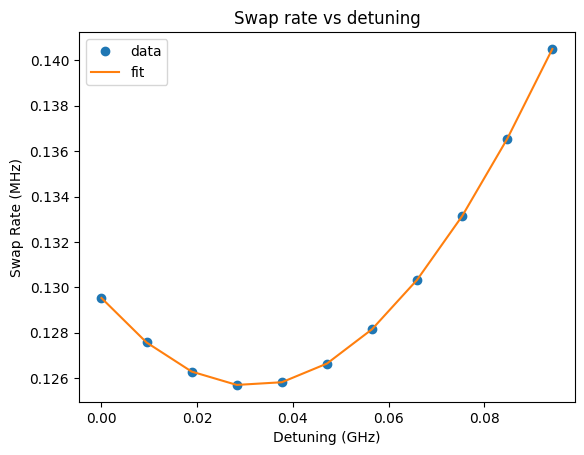

dressed detuning: 5.0 MHz
g: 10.0 MHz


In [71]:
## fit to chevron model

dressed_detuning_guess = dressed_frequencies[1, len(dressed_frequencies)//2] - dressed_frequencies[0, len(dressed_frequencies)//2]
g_guess = 0.01 * 2*np.pi # GHz

initial_guess = (dressed_detuning_guess, g_guess)

popt, pcov = curve_fit(swap_rate_fit, qubit_detunings, swap_rates, p0=initial_guess)

plt.plot(qubit_detunings, swap_rates, marker='o', linestyle='', label='data')
plt.plot(qubit_detunings, swap_rate_fit(qubit_detunings, *popt), label='fit')


plt.xlabel('Detuning (GHz)')
plt.ylabel('Swap Rate (MHz)')

plt.legend()

plt.title('Swap rate vs detuning')
plt.show()

print(f'dressed detuning: {np.round(popt[0]*1e3/2/np.pi, 2)} MHz')
print(f'g: {np.round(popt[1]*1e3/2/np.pi, 2)} MHz')

### 1.3 Measure X + iY

In [72]:
X = qt.sigmax()
Y = qt.sigmay()

X1 = qt.tensor(X, qt.qeye(num_levels))
X2 = qt.tensor(qt.qeye(num_levels), X)

Y1 = qt.tensor(Y, qt.qeye(num_levels))
Y2 = qt.tensor(qt.qeye(num_levels), Y)

In [73]:
time_spacing = 0.005 # ns
number_of_times = 200000

times = np.linspace(0, (number_of_times-1)*time_spacing, number_of_times)
psi0 = (qt.basis([num_levels, num_levels], [1, 0]) + qt.basis([num_levels, num_levels], [0, 0]))/np.sqrt(2)

In [74]:
H = generate_Hamiltonian(omega_1, omega_2, g, U, [a1, a2])

# time evolution
result = qt.sesolve(H, psi0, times, e_ops=[X1 + 1j*Y1])

XY_measurement = result.expect[0]

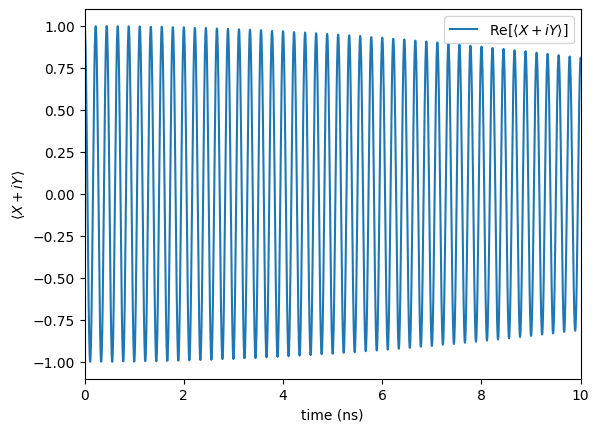

In [75]:
plt.plot(times, XY_measurement.real, label=r'Re$[\langle X + iY \rangle]$')
# plt.plot(times, XY_measurement.imag, label=r'Im$[\langle X + iY \rangle]$')
# plt.plot(times, np.abs(XY_measurement), label=r'$|\langle X + iY \rangle|$')

# plt.plot(times, np.cos(4.5*2*np.pi*times), label='test')

plt.xlim(0, 10)

plt.xlabel('time (ns)')
plt.ylabel(r'$\langle X + iY \rangle$')

plt.legend()
plt.show()

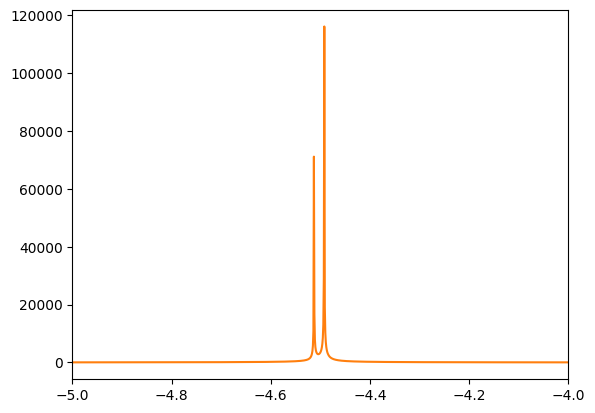

In [76]:
### fft

XY_fft = fft(XY_measurement)

number_of_times = len(times)
time_spacing = times[1] - times[0]

XY_fft_freqs = fftfreq(number_of_times, time_spacing)

# cutoff edges of plot
cutoff_index = number_of_times//2

plt.plot(XY_fft_freqs[0:cutoff_index], np.abs(XY_fft[0:cutoff_index]))
plt.plot(XY_fft_freqs[number_of_times - cutoff_index+1:], np.abs(XY_fft[number_of_times - cutoff_index+1:]))

plt.xlim(-5, -4)

plt.show()

In [77]:
len(XY_fft_freqs)
XY_fft_freqs[15000:15050]

array([15.   , 15.001, 15.002, 15.003, 15.004, 15.005, 15.006, 15.007,
       15.008, 15.009, 15.01 , 15.011, 15.012, 15.013, 15.014, 15.015,
       15.016, 15.017, 15.018, 15.019, 15.02 , 15.021, 15.022, 15.023,
       15.024, 15.025, 15.026, 15.027, 15.028, 15.029, 15.03 , 15.031,
       15.032, 15.033, 15.034, 15.035, 15.036, 15.037, 15.038, 15.039,
       15.04 , 15.041, 15.042, 15.043, 15.044, 15.045, 15.046, 15.047,
       15.048, 15.049])

first peak index: 195508
first peak frequency: 4492.0 MHz


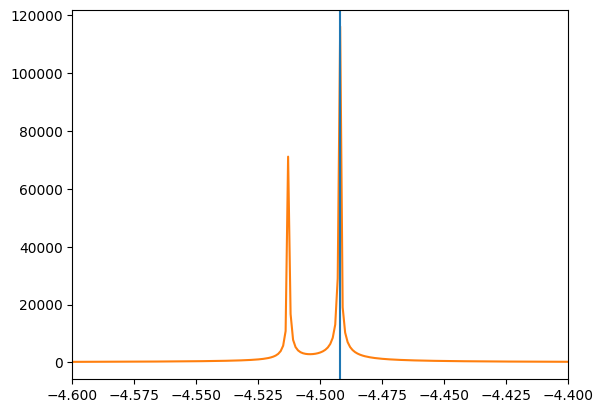

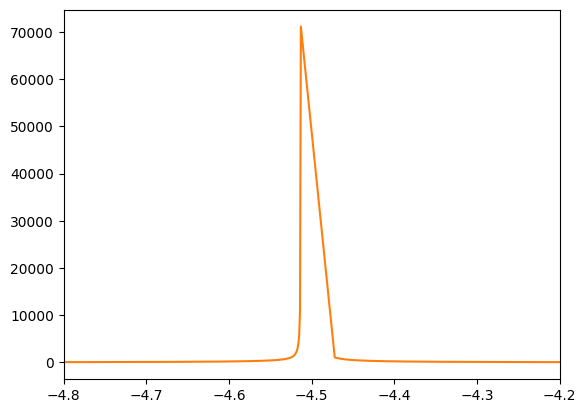

second peak index: 195487
second peak frequency: 4513.0 MHz
Average frequency: 4502.5 MHz


In [78]:
first_peak_index = np.argmax(np.abs(XY_fft))
first_peak_frequency = XY_fft_freqs[first_peak_index]
print(f'first peak index: {first_peak_index}')
print(f'first peak frequency: {np.round(np.abs(first_peak_frequency*1e3), 2)} MHz')

plt.plot(XY_fft_freqs[0:cutoff_index], np.abs(XY_fft[0:cutoff_index]))
plt.plot(XY_fft_freqs[number_of_times - cutoff_index+1:], np.abs(XY_fft[number_of_times - cutoff_index+1:]))

ignore_index_range = 40

plt.axvline(XY_fft_freqs[first_peak_index])
plt.xlim(-4.6, -4.4)
plt.show()


mask = np.ones(len(XY_fft), dtype=bool)
mask[np.arange(first_peak_index - ignore_index_range//2,  first_peak_index + ignore_index_range//2, 1)] = False
ignored_fft = XY_fft[mask]
ignored_fft_freqs = XY_fft_freqs[mask]



plt.plot(ignored_fft_freqs[0:cutoff_index], np.abs(ignored_fft[0:cutoff_index]))
plt.plot(ignored_fft_freqs[number_of_times - cutoff_index+1:], np.abs(ignored_fft[number_of_times - cutoff_index+1:]))
plt.xlim(-4.8, -4.2)
plt.show()


second_peak_index = np.argmax(np.abs(ignored_fft))
second_peak_frequency = ignored_fft_freqs[second_peak_index]

print(f'second peak index: {np.round(second_peak_index)}')
print(f'second peak frequency: {np.round(np.abs(second_peak_frequency*1e3), 2)} MHz')


average_frequency = (first_peak_frequency + second_peak_frequency)/2

print(f'Average frequency: {np.round(np.abs(average_frequency)*1e3, 2)} MHz')

In [79]:
def two_cos_fit(x, A, B, omega_1, omega_2, C):
    return A*np.cos(x*omega_1) + B*np.cos(x*omega_2) + C

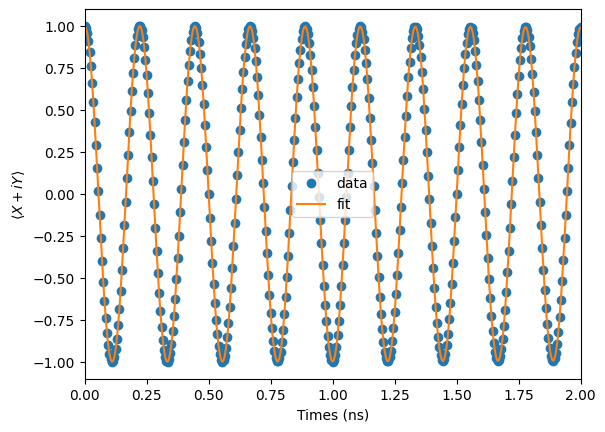

Frequencies: [-4.492 -4.513] GHz
Average Frequency: -4.503 GHz


In [80]:
## two cosine fit


initial_guess = (1, 1, first_peak_frequency*2*np.pi, second_peak_frequency*2*np.pi, 0)

popt, pcov = curve_fit(two_cos_fit, times, XY_measurement.real, p0=initial_guess)

plt.plot(times, XY_measurement.real, marker='o', linestyle='', label='data')
plt.plot(times, two_cos_fit(times, *popt), label='fit')
# plt.plot(times, two_cos_fit(times, *initial_guess), label='guess')

plt.xlim(0, 2)

plt.xlabel('Times (ns)')
plt.ylabel(r'$\langle X + iY \rangle$')

plt.legend()

plt.show()

print(f'Frequencies: {np.round(popt[[2,3]]/2/np.pi, 3)} GHz')
print(f'Average Frequency: {np.round(np.sum(popt[[2,3]])/2/2/np.pi, 3)} GHz')

In this case, for two coupled qubits, the swap spectroscopy gives the effective coupling as well as the difference between the bare frequencies. The X + iY spectroscopy gives the dressed frequencies as well as the average of the bare and dressed frequencies. Here, the bare frequencies are the actual frequencies of the qubits not dressed by the qubit-qubit coupling

# 2. 3 Qubits
Now let's consider two qubits again, but this time with a third coupled qubit. The third qubit is off resonance by still shifts the other qubits dispersively.

### 2.1 Define functions and operators

In [81]:
def generate_Hamiltonian_3Q(omega_1, omega_2, omega_3, g_12, g_13, g_23, U, annihilation_operators):
    
    a1, a2, a3 = annihilation_operators
    
    H = omega_1 * a1.dag()*a1 + omega_2 * a2.dag()*a2 + omega_3 * a3.dag()*a3
    H += U*(a1.dag()*a1*(a1.dag()*a1 - 1) + a2.dag()*a2*(a2.dag()*a2 - 1) + a3.dag()*a3*(a3.dag()*a3 - 1))
    H += g_12*(a1.dag()*a2 + a2.dag()*a1) + g_13*(a1.dag()*a3 + a3.dag()*a1) + g_23*(a3.dag()*a2 + a2.dag()*a3)
    
    return H

In [82]:
num_levels = 2
num_qubits = 3

a = qt.destroy(num_levels)

a1 = qt.tensor(a, qt.qeye(num_levels), qt.qeye(num_levels))
a2 = qt.tensor(qt.qeye(num_levels), a, qt.qeye(num_levels))
a3 = qt.tensor(qt.qeye(num_levels), qt.qeye(num_levels), a)

annihilation_operators = [a1, a2, a3]

### 2.2 Swap Spectroscopy

In [83]:
omega_1 = 4.500 * 2*np.pi # GHz
omega_2 = 4.505 * 2*np.pi # GHz
omega_3 = 5.000 * 2*np.pi # GHz

g_12 = 0.010 * 2*np.pi # GHz
g_13 = 0.100 * 2*np.pi # GHz
g_23 = 0.100 * 2*np.pi # GHz

U = -0.2 * 2*np.pi # GHz

times = np.linspace(0, 400, 1001)

psi0 = qt.basis([num_levels, num_levels, num_levels], [1, 0, 0])

qubit_detunings = np.linspace((omega_2 - omega_1)/2/np.pi - 0.01, (omega_2 - omega_1)/2/np.pi + 0.01, 21) * 2*np.pi # GHz
qubit_detunings = np.linspace(0, (omega_2 - omega_1)/2/np.pi + 0.01, 11) * 2*np.pi # GHz


In [84]:

dressed_frequencies = np.zeros((num_qubits, len(qubit_detunings)))
bare_frequencies = np.zeros(dressed_frequencies.shape)

populations = np.zeros((num_qubits, len(qubit_detunings), len(times)))

for i in range(len(qubit_detunings)):
    
    detuning = qubit_detunings[i]
    
    H = generate_Hamiltonian_3Q(omega_1 + detuning, omega_2, omega_3, g_12, g_13, g_23, U, annihilation_operators)
    
    # eigenenergies
    eigenenergies, eigenstates = H.eigenstates()
    eigenenergies_particle_number, eigenstates_particle_number = sort_by_number_particle(eigenenergies, eigenstates, annihilation_operators)
    
    dressed_frequencies[0, i] = eigenenergies_particle_number[1][0]/2/np.pi
    dressed_frequencies[1, i] = eigenenergies_particle_number[1][1]/2/np.pi
    dressed_frequencies[2, i] = eigenenergies_particle_number[1][2]/2/np.pi
    
    bare_frequencies[0, i] = (omega_1 + detuning)/2/np.pi
    bare_frequencies[1, i] = omega_2/2/np.pi
    bare_frequencies[2, i] = omega_3/2/np.pi
    
    # time evolution
    
    result = qt.sesolve(H, psi0, times, e_ops=[a1.dag()*a1, a2.dag()*a2, a3.dag()*a3])
    
    populations[:,i,:] = result.expect

In [85]:
print(f'Dressed frequencies at starting point')
H = generate_Hamiltonian_3Q(omega_1, omega_2, omega_3, g_12, g_13, g_23, U, [a1, a2, a3])
eigenenergies, eigenstates = H.eigenstates()
eigenenergies_particle_number, eigenstates_particle_number = sort_by_number_particle(eigenenergies, eigenstates, annihilation_operators)

print(f'{np.round(eigenenergies_particle_number[1][0]/2/np.pi, 3)}')
print(f'{np.round(eigenenergies_particle_number[1][1]/2/np.pi, 3)}')
print(f'{np.round(eigenenergies_particle_number[1][2]/2/np.pi, 3)}')


Dressed frequencies at starting point
4.474
4.493
5.038


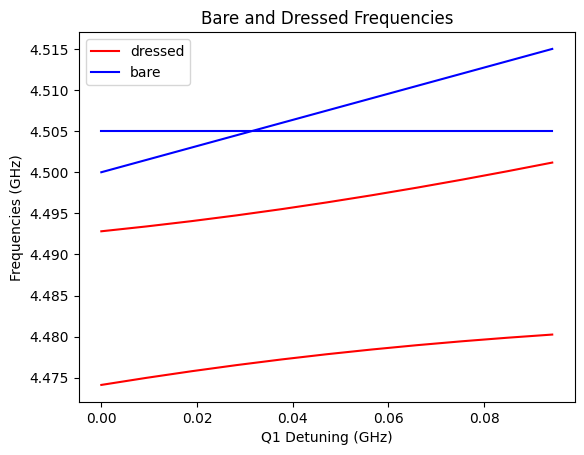

In [86]:
plt.plot(qubit_detunings, dressed_frequencies[0, :], color='red', label='dressed')
plt.plot(qubit_detunings, dressed_frequencies[1, :], color='red')
# plt.plot(qubit_detunings, dressed_frequencies[2, :], color='red')

plt.plot(qubit_detunings, bare_frequencies[0, :], color='blue', label='bare')
plt.plot(qubit_detunings, bare_frequencies[1, :], color='blue')
# plt.plot(qubit_detunings, bare_frequencies[2, :], color='blue')

plt.xlabel('Q1 Detuning (GHz)')
plt.ylabel('Frequencies (GHz)')

plt.title('Bare and Dressed Frequencies')


plt.legend()
plt.show()

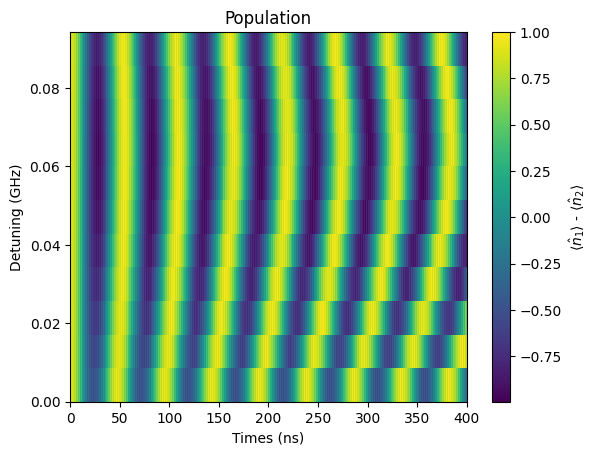

In [87]:
im = plt.imshow(populations[0,:,:] - populations[1,:,:], aspect='auto', interpolation='none', extent=(times[0], times[-1], qubit_detunings[0], qubit_detunings[-1]))

plt.xlabel('Times (ns)')
plt.ylabel('Detuning (GHz)')

plt.colorbar(im, label=r'$\langle \hat{n}_1 \rangle$ - $\langle \hat{n}_2 \rangle$')

plt.title('Population')
plt.show()


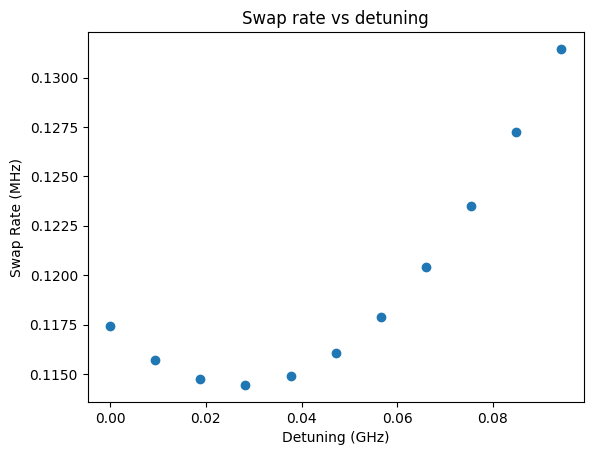

In [88]:
### fit each slice to sinusoid

plot_fits = False
swap_rates = np.zeros((len(qubit_detunings)))

for i in range(len(qubit_detunings)):
    
    
    population_difference = populations[0,i,:] - populations[1,i,:]
    
    population_difference_fft = fft(population_difference)
    
    number_of_times = len(times)
    time_spacing = times[1] - times[0]
    
    population_difference_fft_freqs = fftfreq(number_of_times, time_spacing)
    
    peak_index = np.argmax(np.abs(population_difference_fft[1:number_of_times//2]))
    swap_rate_guess = population_difference_fft_freqs[1:number_of_times//2][peak_index]*2*np.pi
    
   
    if plot_fits:
        print(f'peak index: {peak_index}')
        print(f'swap rate guess: {swap_rate_guess*1e3/2/np.pi} MHz')
    
        plt.plot(population_difference_fft_freqs[1:number_of_times//2], np.abs(population_difference_fft[1:number_of_times//2]))
        plt.show()
    
    amplitude_guess = 1
    initial_guess = (amplitude_guess, swap_rate_guess, 0)
    bounds = ((-np.inf, 0, -np.inf), (np.inf, np.inf, np.inf))
    
    popt, pcov = curve_fit(cos_fit, times, population_difference, p0=initial_guess, bounds=bounds)
    
    swap_rates[i] = popt[1]
    
    if plot_fits:

        plt.plot(times, population_difference, marker='o', linestyle='', label='data')
        plt.plot(times, cos_fit(times, *popt), label='fit')    
        plt.plot(times, cos_fit(times, *initial_guess), label='guess')    

        plt.xlabel('Time (ns)')
        plt.ylabel('Population Difference')

        plt.legend()
        plt.show()
    
plt.plot(qubit_detunings, swap_rates, marker='o', linestyle='')
plt.xlabel('Detuning (GHz)')
plt.ylabel('Swap Rate (MHz)')

plt.title('Swap rate vs detuning')
plt.show()

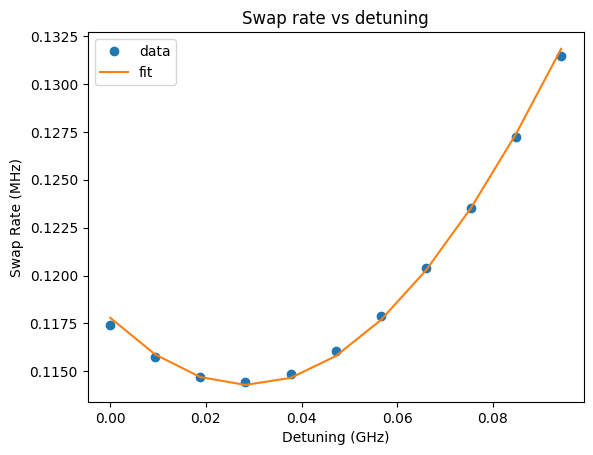

dressed detuning: 4.54 MHz
g: 9.09 MHz


In [89]:
## fit to chevron model

dressed_detuning_guess = dressed_frequencies[1, len(dressed_frequencies)//2] - dressed_frequencies[0, len(dressed_frequencies)//2]
g_guess = 0.01 * 2*np.pi # GHz

initial_guess = (dressed_detuning_guess, g_guess)

popt, pcov = curve_fit(swap_rate_fit, qubit_detunings, swap_rates, p0=initial_guess)

plt.plot(qubit_detunings, swap_rates, marker='o', linestyle='', label='data')
plt.plot(qubit_detunings, swap_rate_fit(qubit_detunings, *popt), label='fit')


plt.xlabel('Detuning (GHz)')
plt.ylabel('Swap Rate (MHz)')

plt.legend()

plt.title('Swap rate vs detuning')
plt.show()

dressed_detuning = popt[0]/2/np.pi
print(f'dressed detuning: {np.round(dressed_detuning*1e3, 2)} MHz')
print(f'g: {np.round(popt[1]*1e3/2/np.pi, 2)} MHz')

dressed_g = popt[1]

### 2.3 Measure X + iY

In [90]:
X = qt.sigmax()
Y = qt.sigmay()

X1 = qt.tensor(X, qt.qeye(num_levels), qt.qeye(num_levels))
Y1 = qt.tensor(Y, qt.qeye(num_levels), qt.qeye(num_levels))

X2 = qt.tensor(qt.qeye(num_levels), X, qt.qeye(num_levels))
Y2 = qt.tensor(qt.qeye(num_levels), Y, qt.qeye(num_levels))

X3 = qt.tensor(qt.qeye(num_levels), qt.qeye(num_levels), X)
Y3 = qt.tensor(qt.qeye(num_levels), qt.qeye(num_levels), Y)

In [91]:
time_spacing = 0.005 # ns
number_of_times = 200000

times = np.linspace(0, (number_of_times-1)*time_spacing, number_of_times)
psi0 = (qt.basis([num_levels, num_levels, num_levels], [1, 0, 0]) + qt.basis([num_levels, num_levels, num_levels], [0, 0, 0]))/np.sqrt(2)

In [92]:
H = generate_Hamiltonian_3Q(omega_1, omega_2, omega_3, g_12, g_13, g_23, U, annihilation_operators)

# time evolution
result = qt.sesolve(H, psi0, times, e_ops=[X1 + 1j*Y1])

XY_measurement = result.expect[0]

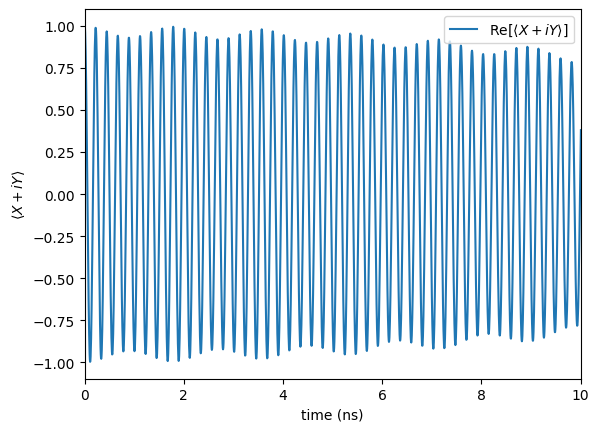

In [93]:
plt.plot(times, XY_measurement.real, label=r'Re$[\langle X + iY \rangle]$')
# plt.plot(times, XY_measurement.imag, label=r'Im$[\langle X + iY \rangle]$')
# plt.plot(times, np.abs(XY_measurement), label=r'$|\langle X + iY \rangle|$')

# plt.plot(times, np.cos(4.5*2*np.pi*times), label='test')

plt.xlim(0, 10)

plt.xlabel('time (ns)')
plt.ylabel(r'$\langle X + iY \rangle$')

plt.legend()
plt.show()

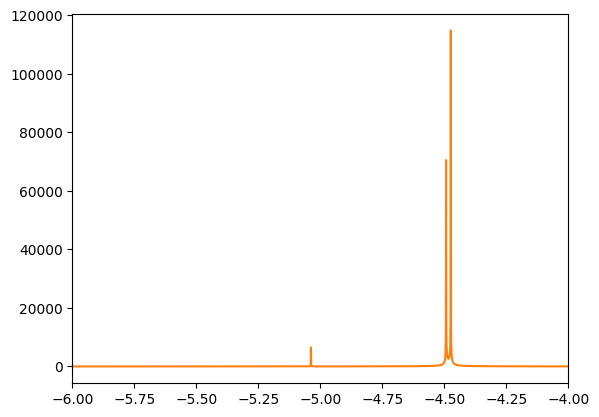

In [94]:
### fft

XY_fft = fft(XY_measurement)

number_of_times = len(times)
time_spacing = times[1] - times[0]

XY_fft_freqs = fftfreq(number_of_times, time_spacing)

# cutoff edges of plot
cutoff_index = number_of_times//2

plt.plot(XY_fft_freqs[0:cutoff_index], np.abs(XY_fft[0:cutoff_index]))
plt.plot(XY_fft_freqs[number_of_times - cutoff_index+1:], np.abs(XY_fft[number_of_times - cutoff_index+1:]))

plt.xlim(-5, -4)
plt.xlim(-6, -4)

plt.show()

first peak index: 195526
first peak frequency: 4474.0 MHz


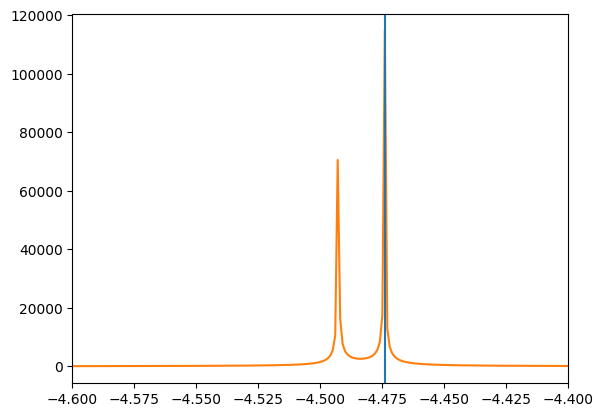

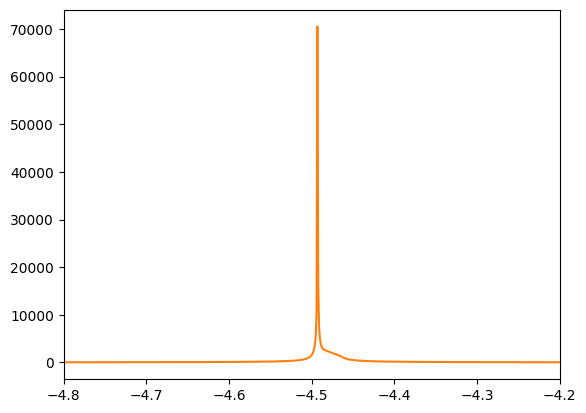

second peak index: 195507
second peak frequency: 4493.0 MHz
Average frequency: 4483.5 MHz


In [95]:
first_peak_index = np.argmax(np.abs(XY_fft))
first_peak_frequency = XY_fft_freqs[first_peak_index]
print(f'first peak index: {first_peak_index}')
print(f'first peak frequency: {np.round(np.abs(first_peak_frequency*1e3), 2)} MHz')

plt.plot(XY_fft_freqs[0:cutoff_index], np.abs(XY_fft[0:cutoff_index]))
plt.plot(XY_fft_freqs[number_of_times - cutoff_index+1:], np.abs(XY_fft[number_of_times - cutoff_index+1:]))

ignore_index_range = 20

plt.axvline(XY_fft_freqs[first_peak_index])
plt.xlim(-4.6, -4.4)
plt.show()


mask = np.ones(len(XY_fft), dtype=bool)
mask[np.arange(first_peak_index - ignore_index_range//2,  first_peak_index + ignore_index_range//2, 1)] = False
ignored_fft = XY_fft[mask]
ignored_fft_freqs = XY_fft_freqs[mask]



plt.plot(ignored_fft_freqs[0:cutoff_index], np.abs(ignored_fft[0:cutoff_index]))
plt.plot(ignored_fft_freqs[number_of_times - cutoff_index+1:], np.abs(ignored_fft[number_of_times - cutoff_index+1:]))
plt.xlim(-4.8, -4.2)
plt.show()


second_peak_index = np.argmax(np.abs(ignored_fft))
second_peak_frequency = ignored_fft_freqs[second_peak_index]

print(f'second peak index: {np.round(second_peak_index)}')
print(f'second peak frequency: {np.round(np.abs(second_peak_frequency*1e3), 2)} MHz')


average_frequency = (first_peak_frequency + second_peak_frequency)/2

print(f'Average frequency: {np.round(np.abs(average_frequency)*1e3, 2)} MHz')

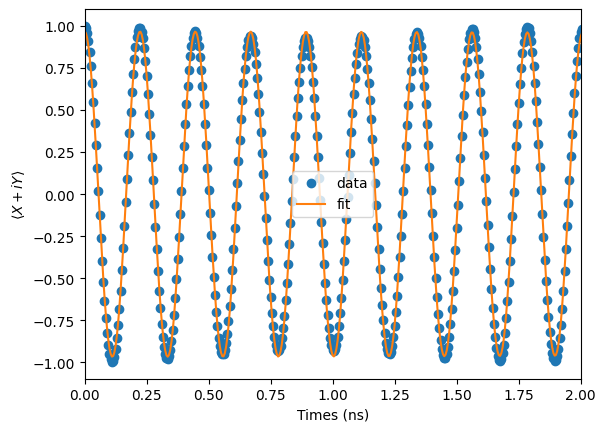

Frequencies: [-4.474 -4.493] GHz
Average Frequency: -4.483 GHz


In [96]:
## two cosine fit


initial_guess = (1, 1, first_peak_frequency*2*np.pi, second_peak_frequency*2*np.pi, 0)

popt, pcov = curve_fit(two_cos_fit, times, XY_measurement.real, p0=initial_guess)

plt.plot(times, XY_measurement.real, marker='o', linestyle='', label='data')
plt.plot(times, two_cos_fit(times, *popt), label='fit')
# plt.plot(times, two_cos_fit(times, *initial_guess), label='guess')

plt.xlim(0, 2)

plt.xlabel('Times (ns)')
plt.ylabel(r'$\langle X + iY \rangle$')

plt.legend()

plt.show()

print(f'Frequencies: {np.round(popt[[2,3]]/2/np.pi, 3)} GHz')
print(f'Average Frequency: {np.round(np.sum(popt[[2,3]])/2/2/np.pi, 3)} GHz')

average_frequency = np.abs(np.sum(popt[[2,3]])/2/2/np.pi)

In [97]:
calculated_frequency_1 = average_frequency + dressed_detuning/2
calculated_frequency_2 = average_frequency - dressed_detuning/2

print(f'calculated frequency 1: {np.round(calculated_frequency_1, 3)} GHz')
print(f'calculated frequency 2: {np.round(calculated_frequency_2, 3)} GHz')

calculated frequency 1: 4.486 GHz
calculated frequency 2: 4.481 GHz


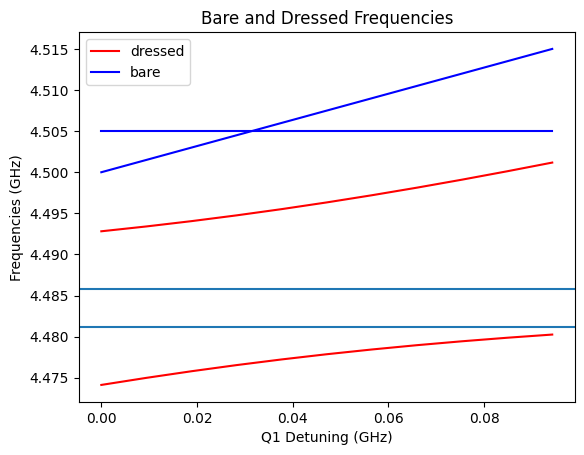

In [98]:
plt.plot(qubit_detunings, dressed_frequencies[0, :], color='red', label='dressed')
plt.plot(qubit_detunings, dressed_frequencies[1, :], color='red')
# plt.plot(qubit_detunings, dressed_frequencies[2, :], color='red')

plt.plot(qubit_detunings, bare_frequencies[0, :], color='blue', label='bare')
plt.plot(qubit_detunings, bare_frequencies[1, :], color='blue')
# plt.plot(qubit_detunings, bare_frequencies[2, :], color='blue')

plt.axhline(calculated_frequency_1)
plt.axhline(calculated_frequency_2)

plt.xlabel('Q1 Detuning (GHz)')
plt.ylabel('Frequencies (GHz)')

plt.title('Bare and Dressed Frequencies')


plt.legend()
plt.show()

Conclusion:

Swap measurements give the difference between Q1 and Q2 bare frequencies, which the paper is implying is the same as the dressed frequency difference?? I guess it depends on the mapping between voltage/flux/frequency to detuning and whether detuning is defined in terms of bare or dressed frequencies.

# 3. Fit Model Hamiltonians

### 3.1 Fit to two qubit model

In [99]:
def get_two_qubit_frequencies(omega_1, omega_2, g, U, num_levels):
    
    a = qt.destroy(num_levels)

    a1 = qt.tensor(a, qt.qeye(num_levels))
    a2 = qt.tensor(qt.qeye(num_levels), a)
    
    H = generate_Hamiltonian(omega_1, omega_2, g, U, [a1, a2])
    
    eigenenergies, eigenstates = H.eigenstates()
    eigenenergies_particle_number, eigenstates_particle_number = sort_by_number_particle(eigenenergies, eigenstates, [a1, a2])
    
    single_particle_energies = eigenenergies_particle_number[1]
    
    return single_particle_energies
    
    
def cost_function_two_qubit(x, g, U, expected_dressed_frequencies, num_levels):
    
    bare_frequencies = x
    
    omega_1, omega_2 = bare_frequencies
    
    dressed_frequencies = get_two_qubit_frequencies(omega_1, omega_2, g, U, num_levels)
    
    return np.sum(np.power(expected_dressed_frequencies - dressed_frequencies, 2))
    

In [100]:
U = -0.2 * 2 * np.pi # GHz

num_levels = 2

expected_dressed_frequencies = dressed_frequencies[:2,0]*2*np.pi
args = (dressed_g, U, expected_dressed_frequencies, num_levels)
x0 = np.array([calculated_frequency_1, calculated_frequency_2])*2*np.pi



In [101]:
result = minimize(cost_function_two_qubit, x0=x0, args=args)
result.x

array([28.18399996, 28.15697142])

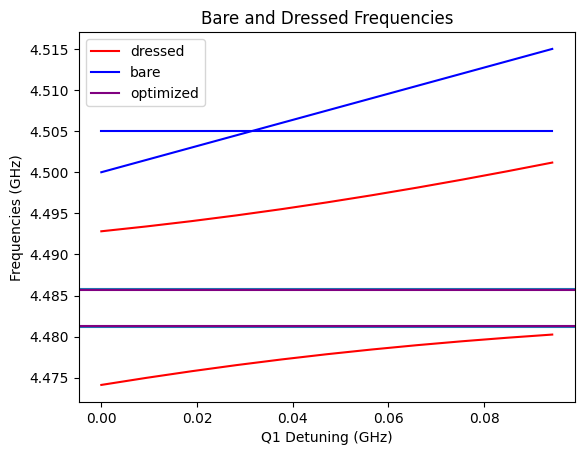

In [102]:
plt.plot(qubit_detunings, dressed_frequencies[0, :], color='red', label='dressed')
plt.plot(qubit_detunings, dressed_frequencies[1, :], color='red')
# plt.plot(qubit_detunings, dressed_frequencies[2, :], color='red')

plt.plot(qubit_detunings, bare_frequencies[0, :], color='blue', label='bare')
plt.plot(qubit_detunings, bare_frequencies[1, :], color='blue')
# plt.plot(qubit_detunings, bare_frequencies[2, :], color='blue')

## plot g^2/delta shifted qubit bare frequencies

# delta_c1 = 

plt.axhline(calculated_frequency_1)
plt.axhline(calculated_frequency_2)

plt.xlabel('Q1 Detuning (GHz)')
plt.ylabel('Frequencies (GHz)')

plt.title('Bare and Dressed Frequencies')



plt.axhline(result.x[0]/2/np.pi, color='purple', label='optimized')
plt.axhline(result.x[1]/2/np.pi, color='purple')

plt.legend()
plt.show()


### 3.2 Fit To Three Qubit Dispersive

In [103]:
# try to fit for bare frequencies by simple dispersive shift

# def cost_function_three_qubit_dispersive(x, g_1c, g_2c, U, expected_dressed_frequencies, num_levels):
def cost_function_three_qubit_dispersive(x, U, expected_dressed_frequencies, num_levels):
    
    bare_frequencies = x
#     omega_1, omega_2, omega_c = bare_frequencies
    omega_1, omega_2, omega_c, g_1c, g_2c = bare_frequencies
    
#     print(omega_1/2/np.pi)
#     print(np.power(g_1c, 2)/2/np.pi/2/np.pi)
#     print(g_1c/2/np.pi)
#     print((omega_1 - omega_c)/2/np.pi)
#     print()
    omega_1_dressed = omega_1 + np.power(g_1c, 2)/(omega_1 - omega_c)
    omega_2_dressed = omega_2 + np.power(g_2c, 2)/(omega_2 - omega_c)
    
    omega_c_dressed = omega_c + np.power(g_1c, 2)/(omega_c - omega_1) + np.power(g_2c, 2)/(omega_c - omega_2)  
    
#     print(omega_1_dressed)
#     print(omega_2_dressed)
#     print(omega_c_dressed)
    
    dressed_frequencies = np.array([omega_1_dressed, omega_2_dressed, omega_c_dressed])
    
    return np.sum(np.power(expected_dressed_frequencies - dressed_frequencies, 2))
#     return np.sum(np.power(expected_dressed_frequencies[:2] - dressed_frequencies[:2], 2))


In [104]:
U = -0.2 * 2 * np.pi # GHz
g_1c = 0.1 * 2 * np.pi # GHz
g_2c = 0.1 * 2 * np.pi # GHz

num_levels = 2

expected_dressed_frequencies = np.array([calculated_frequency_1, calculated_frequency_2, dressed_frequencies[2,0]])*2*np.pi
print(expected_dressed_frequencies)
args = (g_1c, g_2c, U, expected_dressed_frequencies, num_levels)
args = (U, expected_dressed_frequencies, num_levels)
x0 = expected_dressed_frequencies
x0 = np.concatenate([expected_dressed_frequencies, [g_1c, g_2c]])


[28.18476439 28.15622887 31.65503806]


In [105]:
result = minimize(cost_function_three_qubit_dispersive, x0=x0, args=args)
result.x

array([28.27059739, 28.24163783, 31.48379609,  0.52516846,  0.52622969])

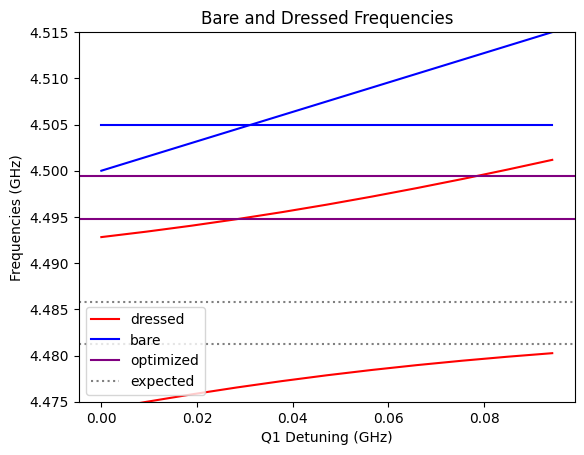

In [106]:
plt.plot(qubit_detunings, dressed_frequencies[0, :], color='red', label='dressed')
plt.plot(qubit_detunings, dressed_frequencies[1, :], color='red')
plt.plot(qubit_detunings, dressed_frequencies[2, :], color='red')

plt.plot(qubit_detunings, bare_frequencies[0, :], color='blue', label='bare')
plt.plot(qubit_detunings, bare_frequencies[1, :], color='blue')
plt.plot(qubit_detunings, bare_frequencies[2, :], color='blue')


# plt.axhline(calculated_frequency_1, label='calculated')
# plt.axhline(calculated_frequency_2)

plt.xlabel('Q1 Detuning (GHz)')
plt.ylabel('Frequencies (GHz)')

plt.title('Bare and Dressed Frequencies')





plt.axhline(result.x[0]/2/np.pi, color='purple', label='optimized')
plt.axhline(result.x[1]/2/np.pi, color='purple')
plt.axhline(result.x[2]/2/np.pi, color='purple')

for i in range(len(expected_dressed_frequencies)):
    label=None
    if i == 0:
        label='expected'
    plt.axhline(expected_dressed_frequencies[i]/2/np.pi, color='gray', linestyle=':', label=label)

plt.ylim(4.475, 4.515)

plt.legend()
plt.show()


### Fit to 3.3 Three Qubits Exact Diagonalization
Construct the Hamiltonian, simulate the swap and X + iY measurements, and fit the bare frequencies (and coupling) that gives the expected dressed frequencies.

In [ ]:
+